<div style="color:#800080; font-size:28px; font-weight:bold;">
Título y datos del alumno    
</div>

**Título: Predecir la aparición de diabetes basándose en medidas de diagnóstico**
  
**Autores:**  
- Cisneros Lovaton, Sarai
- Urbina Castro, George

<div style="color:#800080; font-size:28px; font-weight:bold;">
    1. Introducción y Contexto del Negocio  
</div>

**Contexto**  
El Instituto Nacional de Diabetes y Enfermedades Digestivas y Renales quiere predecir diagnósticamente si un paciente padece diabetes, basándose en ciertas mediciones diagnósticas. En particular, todos los pacientes aquí presentes son mujeres de al menos 21 años de ascendencia indígena pima.

**Definición de variables:**

Variables Predictoras:
- Pregnancies: Número de veces que quedó embarazada
- Glucose: Concentración de glucosa plasmática a las 2 horas en una prueba de tolerancia a la glucosa oral
- BloodPressure: Presión arterial diastólica (mm Hg)
- SkinThickness: Espesor del pliegue cutáneo del tríceps (mm)
- Insulin: Insulina sérica de 2 horas (mu U/ml)
- BMI: Índice de masa corporal (peso en kg/(altura en m)^2)
- DiabetesPedigreeFunction: Función del pedigrí de la diabetes
- Age: Edad (años) 

Variable Objetivo (Target):
- Outcome (0: No tiene diabetes / 1: Tiene diabetes)


**Objetivo de negocio**  

El objetivo es predecir la probabilidad de diabetes (0 = no, 1 = sí) a partir de variables clínicas (glucosa, presión, BMI, edad, etc.) utilizando aprendizaje supervisado. 

**¿Por qué es importante explicar las predicciones?**

En un contexto médico, no basta con que el modelo sea preciso:

Las decisiones afectan diagnósticos y tratamientos.  
Se requiere confianza y trazabilidad.  
Se debe evitar sesgos clínicos.  
Por ello, se incorporan técnicas de Explainable AI (XAI), específicamente SHAP, para entender qué variables influyen y cómo.

**Stakeholders**

👨‍⚕️ Médicos: entender factores de riesgo  
🏥 Instituciones de salud: soporte a decisiones  
📊 Data Scientists: validación y control del modelo  
📋 Reguladores: transparencia del sistema

<div style="color:#800080; font-size:28px; font-weight:bold;">
    Carga de datos y Preprocesamiento
</div>

In [133]:
# 1. Configuración Inicial
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt  # Agregado para visualizaciones
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold, RepeatedStratifiedKFold, GroupKFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, recall_score, roc_auc_score, ConfusionMatrixDisplay
import joblib
import time
from sklearn.tree import DecisionTreeClassifier, plot_tree
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import os
import kagglehub
import xgboost as xgb
from sklearn.svm import SVC

# Semilla aleatoria
RANDOM_STATE = 42

# ML y XAI
import lightgbm as lgb
import shap

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [134]:
!pip install kagglehub

In [135]:
# Cambiar ruta de almacenamiento
os.environ["KAGGLEHUB_CACHE"] = "../data/"
path = kagglehub.dataset_download("uciml/pima-indians-diabetes-database")

print("Descargado en:", path)

Descargado en: ../data/datasets\uciml\pima-indians-diabetes-database\versions\1


In [136]:
df = pd.read_csv("../data/datasets/uciml/pima-indians-diabetes-database/versions/1/diabetes.csv")
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [137]:
# Ver columnas disponibles
print("Columnas:", df.columns.tolist()[:10], "...")
print(f"Dimensiones: {df.shape}")

# Separar Features y Target(Outcome)
TARGET_COL = 'Outcome'
COLS_TO_DROP = [TARGET_COL]

# Eliminamos explícitamente columnas que no aportan valor predictivo o son identificadores.
X = df.drop([col for col in COLS_TO_DROP if col in df.columns], axis=1)
y = df[TARGET_COL]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE)

print(f"\nTrain shape: {X_train.shape}")
print(f"Test shape: {X_test.shape}")
print(f"Distribución target (Train): {y_train.value_counts(normalize=True).to_dict()}")
print("")

X_train.info()

Columnas: ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'] ...
Dimensiones: (768, 9)

Train shape: (614, 8)
Test shape: (154, 8)
Distribución target (Train): {0: 0.6514657980456026, 1: 0.3485342019543974}

<class 'pandas.core.frame.DataFrame'>
Index: 614 entries, 353 to 107
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               614 non-null    int64  
 1   Glucose                   614 non-null    int64  
 2   BloodPressure             614 non-null    int64  
 3   SkinThickness             614 non-null    int64  
 4   Insulin                   614 non-null    int64  
 5   BMI                       614 non-null    float64
 6   DiabetesPedigreeFunction  614 non-null    float64
 7   Age                       614 non-null    int64  
dtypes: float64(2), int64(6)
memory usage: 43.2 KB


<div style="color:#800080; font-size:28px; font-weight:bold;">
Explotación de Datos (EDA)
</div>

In [138]:
num_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
print("Columnas Numéricas detectadas:", num_cols)

# columnas que en Pima usan 0 como indicador implícito de NA
suspect_zero_cols = [c for c in ['Glucose','BloodPressure','SkinThickness','Insulin','BMI'] if c in num_cols]
print("")
print("Columnas donde 0 puede significar missing:", suspect_zero_cols)
print("")
for c in suspect_zero_cols:
    zeros = (X_train[c] == 0).sum()
    print(f"  {c}: zeros = {zeros} ({zeros/len(X_train)*100:.2f}%)")

Columnas Numéricas detectadas: ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']

Columnas donde 0 puede significar missing: ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

  Glucose: zeros = 4 (0.65%)
  BloodPressure: zeros = 23 (3.75%)
  SkinThickness: zeros = 175 (28.50%)
  Insulin: zeros = 290 (47.23%)
  BMI: zeros = 9 (1.47%)


In [139]:
X_train.describe().T

,count,mean,std,min,25%,50%,75%,max
Pregnancies,614.0,3.819218,3.314148,0.000,1.000,3.0000,6.00000,17.000
Glucose,614.0,120.908795,31.561093,0.000,99.000,117.0000,140.00000,199.000
BloodPressure,614.0,69.442997,18.402581,0.000,62.500,72.0000,80.00000,122.000
SkinThickness,614.0,20.776873,15.856433,0.000,0.000,23.0000,32.00000,99.000
Insulin,614.0,78.666124,107.736572,0.000,0.000,40.5000,130.00000,744.000
BMI,614.0,31.973290,7.861364,0.000,27.500,32.3000,36.50000,67.100
DiabetesPedigreeFunction,614.0,0.477428,0.330300,0.084,0.245,0.3825,0.63925,2.329
Age,614.0,33.366450,11.833438,21.000,24.000,29.0000,41.00000,81.000


In [140]:
# Identificar tipos de columnas automáticamente
num_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_features = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

print(f"Features numéricas ({len(num_features)}): {num_features[:10]}...")
print(f"Features categóricas ({len(cat_features)}): {cat_features[:10] if cat_features else 'Ninguna'}")

# Verificar valores nulos
null_pct = (X_train.isnull().sum() / len(X_train)
            * 100).sort_values(ascending=False)
print(f"\nColumnas con más nulos:\n{null_pct.head()}")

Features numéricas (8): ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']...
Features categóricas (0): Ninguna

Columnas con más nulos:
Pregnancies      0.0
Glucose          0.0
BloodPressure    0.0
SkinThickness    0.0
Insulin          0.0
dtype: float64


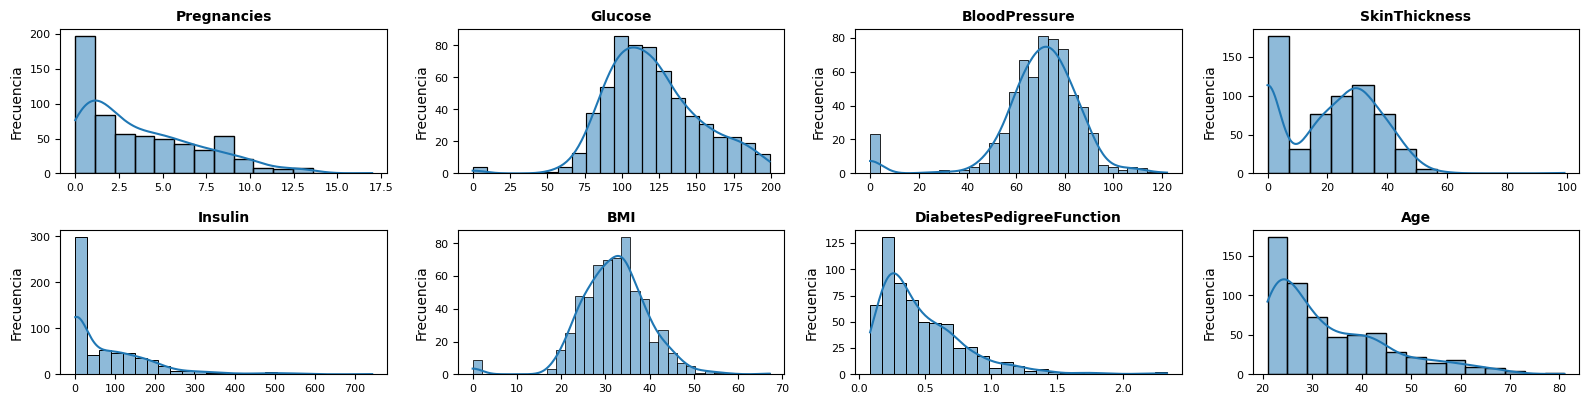

In [141]:
def plot_numeric_distributions(x):
    # Seleccionar columnas numéricas
    columnas_numeric = num_features #x.select_dtypes(include=['float64', 'int64']).columns

    # Número de variables numéricas
    num_vars = len(columnas_numeric)

    # Calcular el número de filas y columnas
    ncols = 4
    nrows = int(np.ceil(num_vars / ncols))

    # Crear subgráficos
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 4, nrows * 2))
    axes = axes.flatten()  # Aplanar la matriz de ejes para fácil indexación

    # Graficar histogramas
    for i, colum in enumerate(columnas_numeric):
        sns.histplot(data=x, x=colum, kde=True, ax=axes[i])
        axes[i].set_title(colum, fontsize=10, fontweight="bold")
        axes[i].tick_params(labelsize=8)
        axes[i].set_xlabel("")
        axes[i].set_ylabel("Frecuencia")

    # Ocultar ejes extra
    for ax in axes[num_vars:]:
        ax.axis('off')

    fig.tight_layout()
    plt.subplots_adjust(top=0.95)
    #fig.suptitle('Distribución de variables numéricas', fontsize=12, fontweight="bold")
    plt.show()

plot_numeric_distributions(X_train)

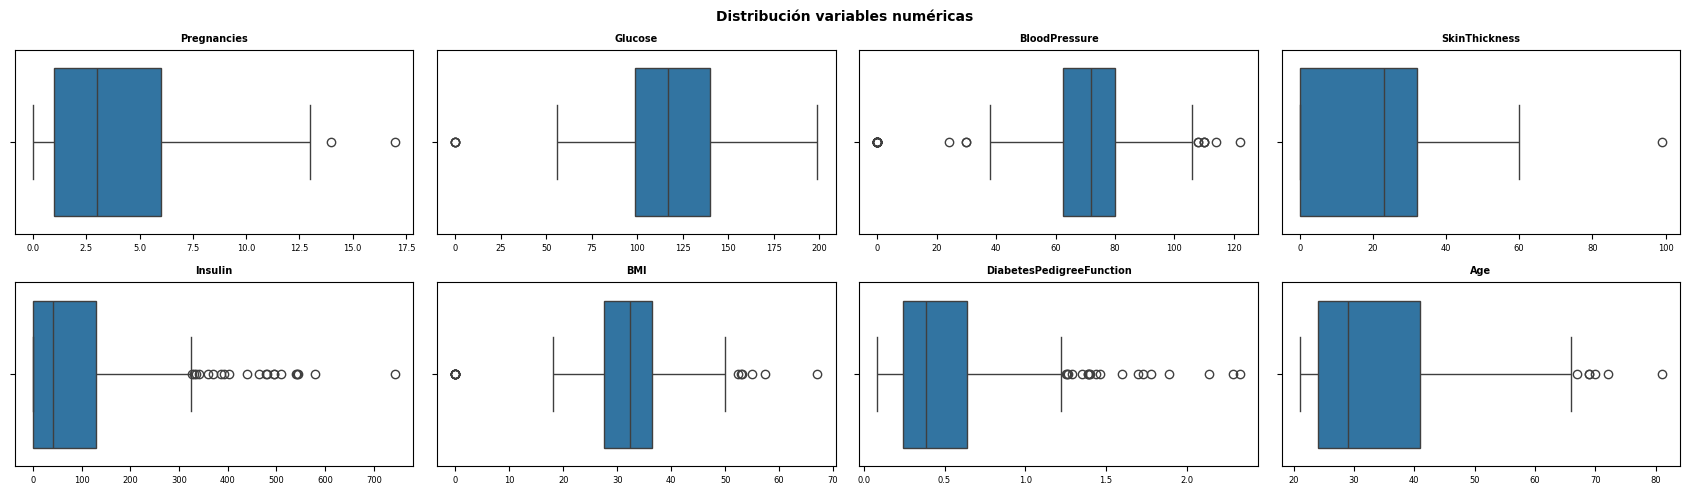

In [142]:
# Ajustar el número de subplots en función del número de columnas numéricas
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(17, 5))
axes = axes.flat
columnas_numeric = num_features #df.select_dtypes(include=['float64', 'int64']).drop(columns=['Outcome']).columns

for i, colum in enumerate(columnas_numeric):
    sns.boxplot(data=X_train, x=colum, ax=axes[i])
    axes[i].set_title(colum, fontsize=7, fontweight="bold")
    axes[i].tick_params(labelsize=6)
    axes[i].set_xlabel("")

fig.tight_layout()
plt.subplots_adjust(top=0.9)
fig.suptitle('Distribución variables numéricas', fontsize=10, fontweight="bold")
plt.show()

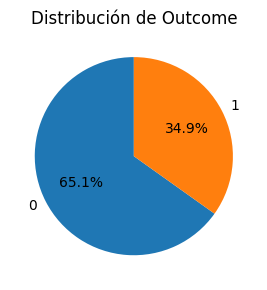

In [143]:
conteo = y_train.value_counts()

plt.figure(figsize=(3,3))
plt.pie(
    conteo.values,
    labels=conteo.index,
    autopct='%1.1f%%',
    startangle=90
)

plt.title("Distribución de Outcome")
plt.tight_layout()
plt.show()

<div style="color:#800080; font-size:28px; font-weight:bold;">
Preprocesamiento (Pipeline)
</div>

In [144]:
cols_validar_ceros = ['Glucose','BloodPressure','SkinThickness','Insulin','BMI']
cols_no_validar_ceros = ['Pregnancies','DiabetesPedigreeFunction','Age']

# Pipeline para columnas con ceros sospechosos
pipeline_ceros = Pipeline([
    ('imputer', SimpleImputer(missing_values=0, strategy='median')),
    #('scaler', StandardScaler())
])

# Pipeline para columnas sin ceros sospechosos
pipeline_normales = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    #('scaler', StandardScaler())
])

In [145]:
preprocessor = ColumnTransformer(
    transformers=[
        ('pipeline_ceros', pipeline_ceros, cols_validar_ceros),
        ('pipeline_normales', pipeline_normales, cols_no_validar_ceros)
    ],
    verbose_feature_names_out=False,
    remainder='drop'  # Lo que no listamos, se borra
)

# Visualizar el preprocesador (sin ajustar aún)
preprocessor

,transformers,"[('pipeline_ceros', ...), ('pipeline_normales', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,False
,force_int_remainder_cols,'deprecated'
,missing_values,0
,strategy,'median'
,fill_value,None


<div style="color:#800080; font-size:28px; font-weight:bold;">
    Entrenamiento de Modelos - train_test_split
</div>

Se configuran 5 modelos: Arbol Simple, Random Forest, Gradient Boosting, XGBoost y SVM
Con hiperparametros por defecto

Se definieron pipelines de clasificación que integran el preprocesamiento de los datos con distintos modelos de aprendizaje automático. En esta etapa, unicamente se especifican los modelos con sus hiperparametros por defecto, sin realizar aún el entrenamiento ni la evaluación.

In [146]:
import lightgbm as lgb

model_LightGBM = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', lgb.LGBMClassifier(random_state=RANDOM_STATE))
])

Luego, realizamos el entrenamiento y evaluación de los 5 modelos. Para cada modelo calculamos métricas de desempeño (Accuraci, AUC, Recall de la clase 1), asi como el tiempo de entrenamiento, las cuales serán necesarias para su comparación y análisis posterior.

<div style="color:#800080; font-size:28px; font-weight:bold;">
    2. Validación Cruzada Avanzada
</div>

**2.1 StratifiedKFold**
- Dataset **desbalanceado** (~35% positivos)
- Mantiene proporción de clases en cada fold

In [147]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores_skf = cross_val_score(model_LightGBM, X, y, cv=skf, scoring='roc_auc')

print(f"AUC-ROC: {scores_skf.mean():.4f} ± {scores_skf.std():.4f}")

[LightGBM] [Info] Number of positive: 214, number of negative: 400
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0,000081 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 660
[LightGBM] [Info] Number of data points in the train set: 614, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0,348534 -> initscore=-0,625489
[LightGBM] [Info] Start training from score -0,625489
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

Es apropiado para esta dataset porque el target está desvalanceado (35% casos positivos)

StratifiedKFold mantiene la proporción de pacientes con y sin diabetes en cada fold, evitando evaluaciones optimistas o pesimistas y evitando folds sin suficientes casos positivos. Evalúa el modelo usando una sola forma de dividir los datos

- El AUC de 0.8072 indica que el modelo presenta una buena capacidad de discriminar entre pacientes con y sin diabates, incluso cuando se trabaja con diferentes subconjuntos.  
- La desviación estándar (0.0220) es baja, lo que indica estabilidad del modelo.


**2.2 RepeatedStratifiedKFold**

- Mayor robustez estadística
- Reduce variabilidad por azar

In [148]:
rskf = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)
scores_rskf = cross_val_score(model_LightGBM, X, y, cv=rskf, scoring='roc_auc')

print(f"AUC-ROC: {scores_rskf.mean():.4f} ± {scores_rskf.std():.4f}")

[LightGBM] [Info] Number of positive: 214, number of negative: 400
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0,000088 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 660
[LightGBM] [Info] Number of data points in the train set: 614, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0,348534 -> initscore=-0,625489
[LightGBM] [Info] Start training from score -0,625489
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

Es apropiado para esta dataset porque el target está desvalanceado (35% casos positivos), lo que puede generar evaluaciones sesgadas si no se controla la proporción de clases.

RepeatedStratifiedKFold mantiene la proporción de pacientes con y sin diabetes en cada fold y repetición, asegurando evaluaciones justas.Cambia las particiones varias veces.Evalúa el modelo en muchos escenarios distintos.

- El AUC de 0.8100 indica que el modelo presenta una buena capacidad de discriminar entre pacientes con y sin diabates, incluso cuando se trabaja con diferentes subconjuntos.  
- La desviación estándar (0.0252) es baja, lo que indica estabilidad del modelo.

Ambas estrategias de validación muestran que el modelo tiene un buen desempeño predictivo (AUC = 0.81). Sin embargo, RepeatedStratifiedKFold ofrece una evaluación más ROBUSTA y confiable que StratifiedKFold, ya que al repetir múltiples veces la validación reduce el efecto del azar y confirma que el rendimiento del modelo es estable y consistente frente a distintas particiones del dataset, ademas las métricas son muy parecidas entre ambos, pero en un contexto médico prevalece la robustes.

**2.3 GroupKFold (simulado)**

- Útil si hay múltiples mediciones por paciente

In [149]:
groups = np.random.randint(0, 100, size=len(X))
gkf = GroupKFold(n_splits=5)
scores_gkf = cross_val_score(model_LightGBM, X, y, cv=gkf, groups=groups, scoring='roc_auc')

print(f"AUC-ROC: {scores_gkf.mean():.4f} ± {scores_gkf.std():.4f}")

[LightGBM] [Info] Number of positive: 206, number of negative: 408
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0,000093 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 673
[LightGBM] [Info] Number of data points in the train set: 614, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0,335505 -> initscore=-0,683391
[LightGBM] [Info] Start training from score -0,683391
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

Para cada estrategia:

Justificar por qué es apropiada para tu dataset  
Reportar métricas con media ± desviación estándar  
Comparar resultados entre estrategias

<div style="color:#800080; font-size:28px; font-weight:bold;">
    3. Explainable AI con SHAP
</div>

In [150]:
# Entrenando
model_shap = model_LightGBM.named_steps['classifier']
model_shap.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 214, number of negative: 400
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0,000091 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 664
[LightGBM] [Info] Number of data points in the train set: 614, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0,348534 -> initscore=-0,625489
[LightGBM] [Info] Start training from score -0,625489
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

,boosting_type,'gbdt'
,num_leaves,31
,max_depth,-1
,learning_rate,0.1
,n_estimators,100
,subsample_for_bin,200000
,objective,None
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


In [151]:
# 1. Crear el "Explainer"
explainer = shap.TreeExplainer(model_shap)

# 2. Calcular SHAP values para el set de prueba
# Esto puede tardar un poco si el dataset es muy grande
print("Calculando SHAP values...")
shap_values = explainer.shap_values(X_test)

# Nota: LightGBM binario devuelve una lista [shap_clase_0, shap_clase_1]
# Nos interesa explicar la Clase 1 (Default/Moroso/Salud)
shap_values_default = shap_values[1]

print(f"Dimensiones de SHAP values: {shap_values_default.shape}")
print("(Filas = Pacientes, Columnas = Features)")




Calculando SHAP values...
Dimensiones de SHAP values: (8,)
(Filas = Pacientes, Columnas = Features)



<div style="color:#800080; font-size:20px; font-weight:bold;">
    3.1 Interpretación Global
</div>

**Bar Plot:** Importancia promedio de features

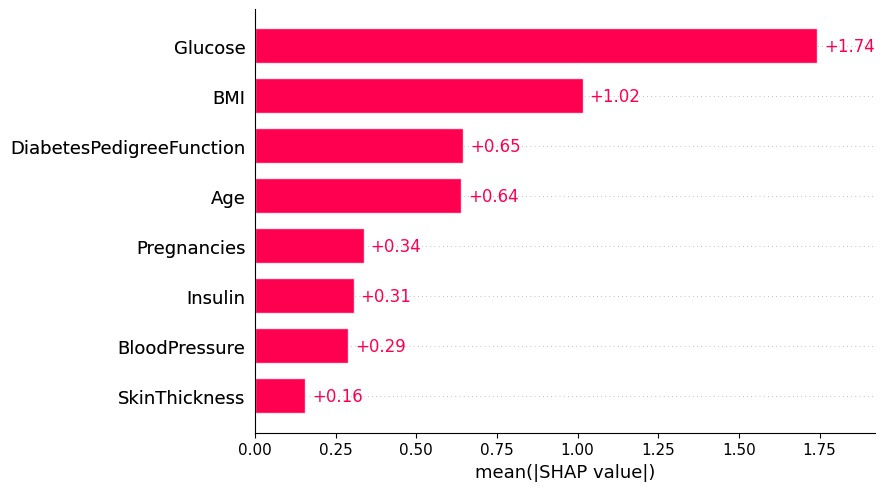

In [152]:
# Construir Explanation correctamente para todo el conjunto de prueba
# La API moderna de SHAP devuelve un Explanation con dimensiones consistentes
explanation = explainer(X_test)

# Bar Plot - Importancia Global (Media de |SHAP|)
shap.plots.bar(explanation, max_display=15)


Interpretación: El modelo identifica que la glucosa y el índice de masa corporal son los principales determinantes del riesgo de diabetes, lo cual es consistente con el conocimiento médico.

**Beeswarm Plot:** Distribución de impactos por feature

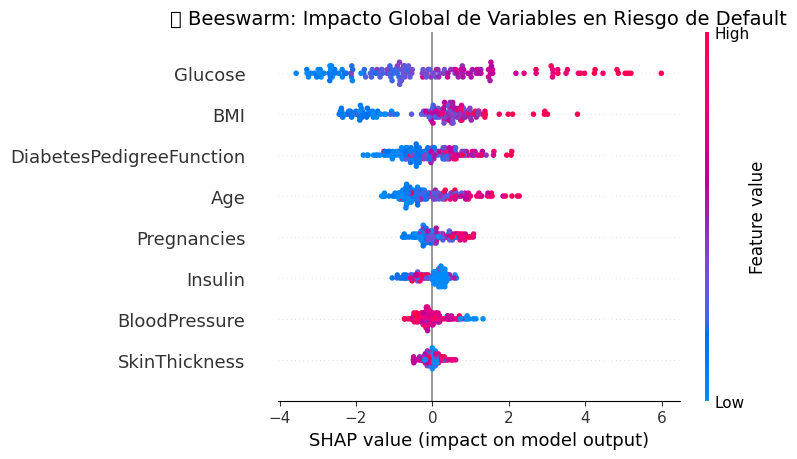

In [153]:
# Beeswarm Plot (Summary Plot con tipo "dot")
plt.figure(figsize=(12, 8))
plt.title("🐝 Beeswarm: Impacto Global de Variables en Riesgo de Default", fontsize=14)
shap.summary_plot(shap_values, X_test, show=True, max_display=15)


Interpretación: 

valores altos en la glucosa (rojo) se concentran a la derecha lo cual hace que aumentan el riesgo de diabetes, y los valores bajos  de glucosa (azul) se ubican a la izquierda, lo que es menos el riego a tener diabetes. 

Los valores de BMI están un poco mas dispersos. Agunos están en la zona del medio entre rojo y azul lo que indica que pacientes con valores similares pueden tener efectos distintos

El impacto de las variables no es uniforme: pacientes con valores similares pueden tener efectos distintos dependiendo de la combinación de factores, lo que justifica el uso de modelos no lineales.

**Heatmap:** Visualización matricial de SHAP values

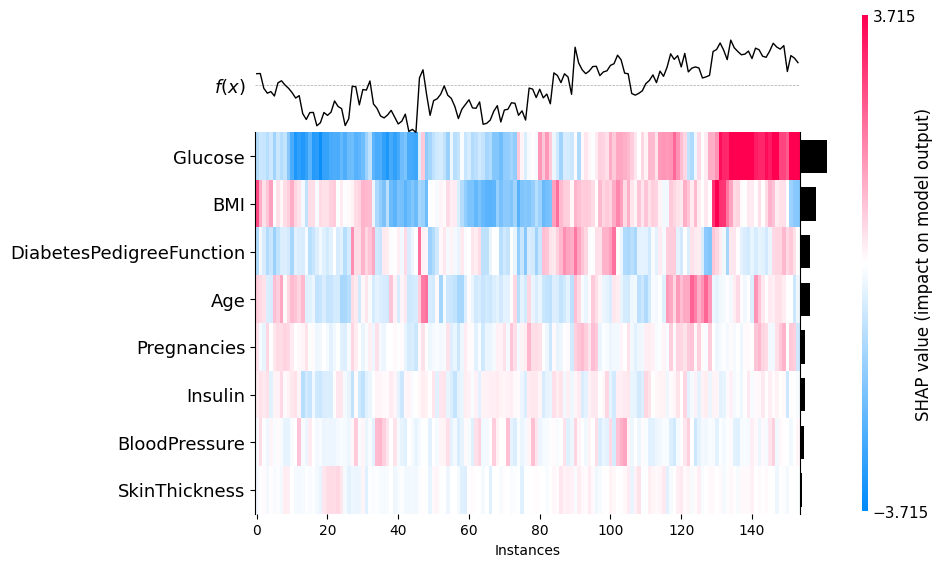

<Axes: xlabel='Instances'>

In [154]:
# Heatmap de SHAP values
shap.plots.heatmap(explanation, max_display=12)

Interpretación:
No se identifican patrones homogéneos claros entre los pacientes. Sin embargo, aunque no hay patrones globales claros entre pacientes, sí se observa un patrón consistente a nivel de la Glucosa, presentado de manera recurrente, confirmando su rol dominante en la predicción del riesgo de diabetes.

<div style="color:#800080; font-size:20px; font-weight:bold;">
    3.2 Interpretación Local
</div>

**Waterfall Plot:** Explicación de 2-3 predicciones individuales

📋 AUDITORÍA DEL PACIENTE MÁS RIESGOSO
Índice del Paciente: 63
Probabilidad de presentar Diabetes: 99.05%


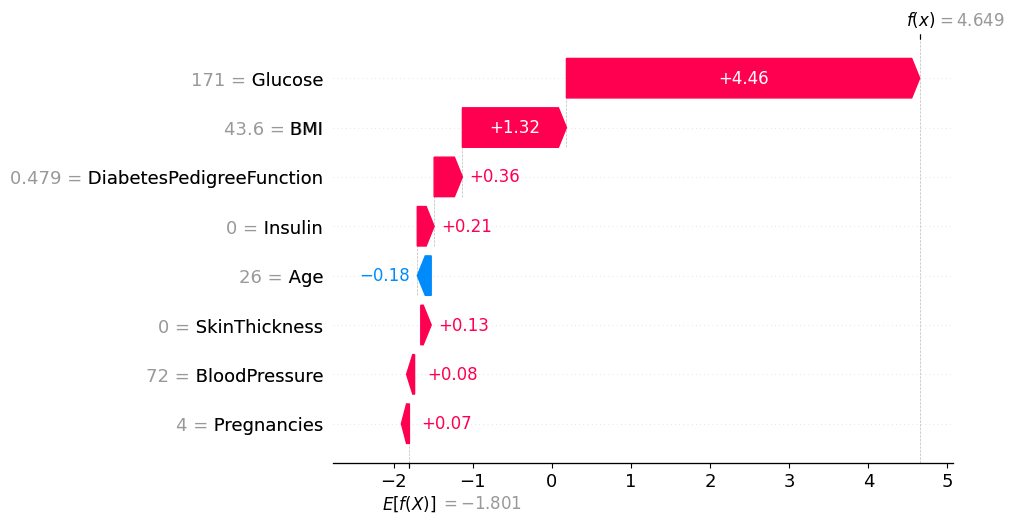

In [155]:
# Elegimos un paciente con alto riesgo para analizar
probs = model_shap.predict_proba(X_test)[:, 1]
high_risk_idx = np.argsort(probs)[-1]  # El paciente más riesgoso

print(f"📋 AUDITORÍA DEL PACIENTE MÁS RIESGOSO")
print(f"{'='*45}")
print(f"Índice del Paciente: {high_risk_idx}")
print(f"Probabilidad de presentar Diabetes: {probs[high_risk_idx]*100:.2f}%")
print(f"{'='*45}")

# Waterfall Plot usando la nueva API
shap.plots.waterfall(explanation[high_risk_idx], max_display=12)


Interpretación:
Este paciente presenta una probabilidad elevada de diabetes (99.05%), principalmente empujado por la Glucosa alta, que es el factor con mayor impacto positivo en la predicción. EL BMI un poco elevado, que refuerza el riesgo metabólico.

El modelo identifica un perfil claramente riesgoso, dominado por niveles elevados de glucosa, lo que explica la alta probabilidad asignada.

📋 AUDITORÍA DEL PACIENTE RIESGOSO
Índice del Paciente: 72
Probabilidad de presentar Diabetes: 18.21%


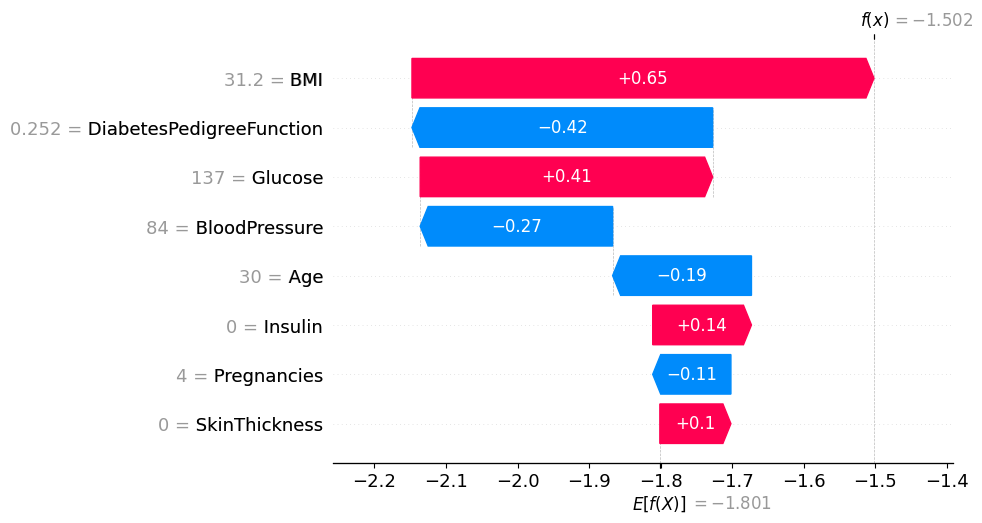

In [156]:
# Elegimos un paciente con alto riesgo para analizar
probs = model_shap.predict_proba(X_test)[:, 1]
high_risk_idx = np.argsort(probs)[-70]  # El paciente más riesgoso que continúa

print(f"📋 AUDITORÍA DEL PACIENTE RIESGOSO")
print(f"{'='*45}")
print(f"Índice del Paciente: {high_risk_idx}")
print(f"Probabilidad de presentar Diabetes: {probs[high_risk_idx]*100:.2f}%")
print(f"{'='*45}")

# Waterfall Plot usando la nueva API
shap.plots.waterfall(explanation[high_risk_idx], max_display=12)


Interpretación:

En este caso, la predicción resulta del equilibrio entre variables de riesgo y varaibles protectoras. Algunas variables como: diabetes pedigreefuction, presión arterial, edad actúan reduciendo parcialmente el riesgo.

El modelo identifica bajo riesgo de diabetes

📋 AUDITORÍA DEL PACIENTE RIESGOSO
Índice del Paciente: 67
Probabilidad de presentar Diabetes: 0.02%


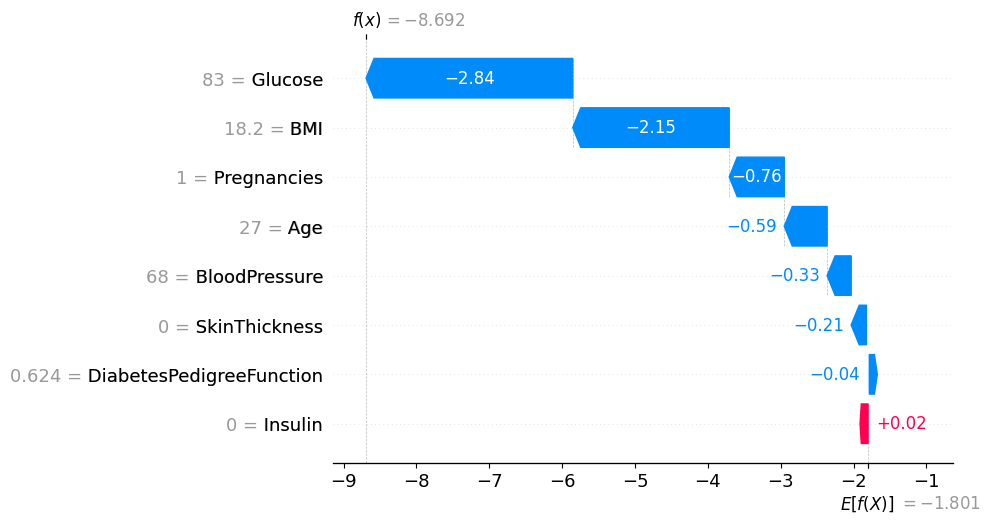

In [157]:
# Elegimos un paciente con alto riesgo para analizar
probs = model_shap.predict_proba(X_test)[:, 1]
high_risk_idx = np.argsort(probs)[-154]  # El paciente más riesgoso que continúa

print(f"📋 AUDITORÍA DEL PACIENTE RIESGOSO")
print(f"{'='*45}")
print(f"Índice del Paciente: {high_risk_idx}")
print(f"Probabilidad de presentar Diabetes: {probs[high_risk_idx]*100:.2f}%")
print(f"{'='*45}")

# Waterfall Plot usando la nueva API
shap.plots.waterfall(explanation[high_risk_idx], max_display=12)


Interpretación:
Este paciente recibe una baja probabilidad de diabetes porque las variables clave empujan la predicción hacia valores negativos.
Ausencia de variables con efecto positivo fuerte.
El modelo identifica un perfil saludable, con bajo riesgo actual de diabetes.


**Decision Plot:** Trayectoria de decisión

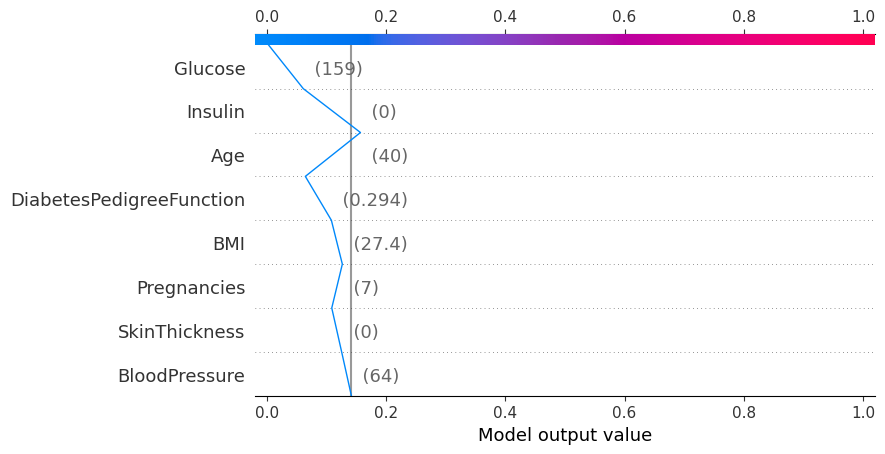

In [158]:
# Decision Plot - Muestra el "camino" de la predicción
# Usamos expected_value[1] porque es clasificación binaria (clase 1 = presenta diabetes)
shap.decision_plot(
    explainer.expected_value,  # Base value para clase 1
    shap_values_default[:100],     # SHAP values de 100 pacientes
    X_test.iloc[:100],             # Features de esos pacientes
    feature_names=X_test.columns.tolist(),
    link='logit'                  # Transforma a probabilidad
)

El modelo comienza desde un riesgo base bajo  

La glucosa es claramente elevada.Produce el mayor desplazamiento hacia la derecha (Principal razón por la que el riesgo de diabetes aumenta).  
Insulina tiene un impacto casi neutro (0), no cambia significativamente la predicción. 
Con la edad hay un ligero aumento del riesgo.  
DiabetesPedigreeFunction, incrementa ligeramente la probabilidad, sin ser decisivo.   
BMI (27.4) refuerza el riesgo iniciado por la glucosa, pero no es extremo.  
Pregnancies contribuye de forma secundaria al riesgo.  
SkinThickness (0) y BloodPressure (64) no generan cambios relevantes.

<div style="color:#800080; font-size:20px; font-weight:bold;">
    3.3 Análisis de Dependencias
</div>

**Scatter Plot:** Relación SHAP vs valor de feature para top 2 variables
Identificar relaciones no lineales e interacciones

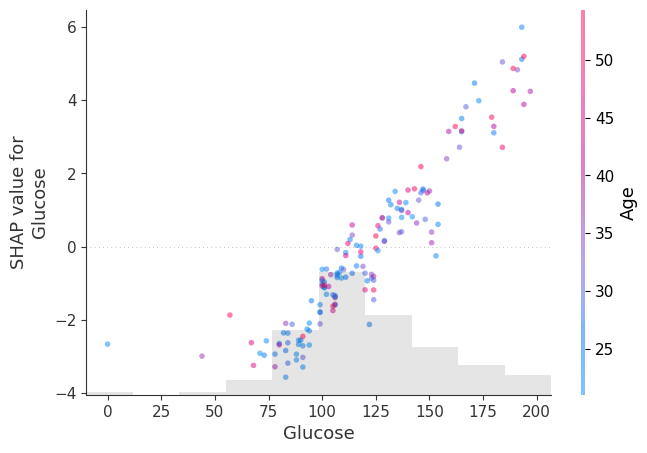

In [159]:
shap.plots.scatter(
    explanation[:, "Glucose"],
    color=explanation,  # Colorea por la variable de mayor interacción
    alpha=0.5
)

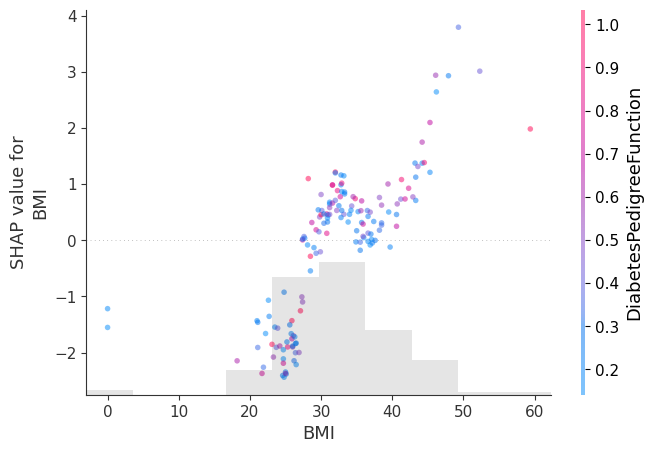

In [160]:
shap.plots.scatter(
    explanation[:, "BMI"],
    color=explanation,  # Colorea por la variable de mayor interacción
    alpha=0.5
)

<div style="color:#800080; font-size:28px; font-weight:bold;">
    4. Serialización del Modelo
</div>

**Joblib**

In [161]:
import sys
import os
import json
import sklearn

# ========================================
# MÉTODO 2: JOBLIB (Estándar ML)
# ========================================
joblib_path = '../app/models/model_joblib.joblib'
auc = roc_auc_score(y_test, model_shap.predict_proba(X_test)[:, 1])
#auc = float(df_results['AUC'][4].round(4))

# Guardar CON metadatos (buena práctica)
artifact = {
    'model': model_shap,
    'feature_names': X.columns.tolist(),
    'target_col': TARGET_COL,
    'auc_test': auc,
    'training_date': pd.Timestamp.now().isoformat(),    
    'lightgbm_version': lgb.__version__
    #'python_version': sklearn.__version__
}

start = time.time()
joblib.dump(artifact, joblib_path, compress=3)  # compress=3 es buen balance
joblib_save_time = time.time() - start

# Cargar
start = time.time()
loaded_artifact = joblib.load(joblib_path)
joblib_load_time = time.time() - start

model_joblib = loaded_artifact['model']

# Verificar
pred_joblib = model_joblib.predict_proba(X_test)[:, 1]
auc_joblib = roc_auc_score(y_test, pred_joblib)

joblib_size = os.path.getsize(joblib_path) / 1024

print(f"📁 Archivo: {joblib_path}")
print(f"📦 Tamaño: {joblib_size:.2f} KB (comprimido)")
print(f"⏱️ Tiempo guardar: {joblib_save_time*1000:.2f} ms")
print(f"⏱️ Tiempo cargar: {joblib_load_time*1000:.2f} ms")
print(f"✅ AUC verificado: {auc_joblib:.4f}")
print(f"\n📋 Metadatos guardados: {list(loaded_artifact.keys())}")

📁 Archivo: ../app/models/model_joblib.joblib
📦 Tamaño: 114.15 KB (comprimido)
⏱️ Tiempo guardar: 11.67 ms
⏱️ Tiempo cargar: 6.42 ms
✅ AUC verificado: 0.8180

📋 Metadatos guardados: ['model', 'feature_names', 'target_col', 'auc_test', 'training_date', 'lightgbm_version']


**Metadatos en JSON**

In [162]:
# ========================================
# MÉTODO 5B: JSON + Metadatos (Para APIs)
# ========================================
json_path = '../app/models/model_metadata.json'

# Guardar metadatos en JSON (legible por cualquier lenguaje)
metadata = {
    'model_type': 'LightGBM',
    'model_file': 'model_texto.txt',
    'feature_names': X.columns.tolist(),
    'n_features': len(X.columns.tolist()),
    'target_col': TARGET_COL,
    
    'metrics': {
        'auc_test': round(auc, 4),
        'n_train_samples': len(X_train),
        'n_test_samples': len(X_test)
    },
    
    'training_info': {
        'date': pd.Timestamp.now().isoformat(),
        'version': lgb.__version__           
    }
}

with open(json_path, 'w') as f:
    json.dump(metadata, f, indent=2)

print(f"📁 Metadatos guardados: {json_path}")
print(f"\n📋 Contenido:")
print(json.dumps(metadata, indent=2)[:1000] + "...")

📁 Metadatos guardados: ../app/models/model_metadata.json

📋 Contenido:
{
  "model_type": "LightGBM",
  "model_file": "model_texto.txt",
  "feature_names": [
    "Pregnancies",
    "Glucose",
    "BloodPressure",
    "SkinThickness",
    "Insulin",
    "BMI",
    "DiabetesPedigreeFunction",
    "Age"
  ],
  "n_features": 8,
  "target_col": "Outcome",
  "metrics": {
    "auc_test": 0.818,
    "n_train_samples": 614,
    "n_test_samples": 154
  },
  "training_info": {
    "date": "2025-12-15T15:11:41.794351",
    "version": "4.6.0"
  }
}...


**ONNX**

In [163]:
# ========================================
# MÉTODO 3: ONNX (Multi-lenguaje)
# ========================================
try:
    import onnxmltools
    from onnxmltools.convert import convert_lightgbm
    from onnxconverter_common import FloatTensorType
    import onnxruntime as ort
    ONNX_AVAILABLE = True
except ImportError:
    ONNX_AVAILABLE = False
    print("⚠️ ONNX no instalado. Ejecuta: pip install onnxmltools onnxruntime")

if ONNX_AVAILABLE:
    onnx_path = '../app/models/model_onnx.onnx'

    # Definir el tipo de entrada (n_features como float)
    initial_type = [('input', FloatTensorType([None, len(X.columns.tolist())]))]

    # Convertir modelo
    start = time.time()
    onnx_model = convert_lightgbm(
        model_shap.booster_,  # LightGBM interno
        initial_types=initial_type,
        target_opset=12
    )

    # Guardar
    with open(onnx_path, 'wb') as f:
        f.write(onnx_model.SerializeToString())
    onnx_save_time = time.time() - start

    # Cargar con ONNX Runtime
    start = time.time()
    ort_session = ort.InferenceSession(onnx_path)
    onnx_load_time = time.time() - start

    # Inferencia
    input_name = ort_session.get_inputs()[0].name
    X_test_np = X_test.values.astype(np.float32)

    start = time.time()
    onnx_output = ort_session.run(None, {input_name: X_test_np})
    onnx_inference_time = time.time() - start

    # ONNX devuelve [labels, probabilities]
    pred_onnx = onnx_output[1][:, 1]  # Probabilidad clase 1
    auc_onnx = roc_auc_score(y_test, pred_onnx)

    onnx_size = os.path.getsize(onnx_path) / 1024

    print(f"📁 Archivo: {onnx_path}")
    print(f"📦 Tamaño: {onnx_size:.2f} KB")
    print(f"⏱️ Tiempo conversión+guardado: {onnx_save_time*1000:.2f} ms")
    print(f"⏱️ Tiempo cargar: {onnx_load_time*1000:.2f} ms")
    print(
        f"⏱️ Tiempo inferencia ({len(X_test)} muestras): {onnx_inference_time*1000:.2f} ms")
    print(f"✅ AUC verificado: {auc_onnx:.4f}")

⚠️ ONNX no instalado. Ejecuta: pip install onnxmltools onnxruntime


<div style="color:#800080; font-size:28px; font-weight:bold;">
    5. Conclusiones del Análisis
</div>

*Conclusiones*  
El modelo LightGBM mostró el mejor desempeño global, con un AUC cercano a 0.81, buena estabilidad bajo validación cruzada y adecuada capacidad para diferenciar pacientes con y sin diabetes.
El uso de SHAP permitió explicar las predicciones de forma transparente, confirmando que el modelo toma decisiones coherentes con el conocimiento médico y evaluando el riesgo caso por caso, lo que lo hace adecuado como herramienta de apoyo a la decisión clínica.


*Top 3 variables más importantes y su interpretación*

Glucosa  
Es la variable con mayor impacto en el modelo.
Valores altos incrementan de forma consistente la probabilidad de diabetes.
Su efecto es dominante tanto a nivel global como individual.
la glucosa es el principal marcador predictivo del riesgo de diabetes.

Indice de masa corporal  
Presenta un impacto positivo regular, especialmente en valores elevados.
Refuerza el riesgo cuando se combina con glucosa alta.
el sobrepeso y la obesidad aumentan el riesgo metabólico de diabetes.


Edad  
La edad incrementa gradualmente la probabilidad de diabetes.
Su efecto es moderado pero consistente en muchos pacientes.
el riesgo de diabetes aumenta con la edad, especialmente en adultos mayores.


*Insights de negocio derivados de SHAP*  
El riesgo de diabetes no depende de una sola variable, sino de la combinación de factores clínicos.
Pacientes con probabilidades similares pueden llegar a ese riesgo por razones distintas, lo que justifica evaluaciones personalizadas.
La glucosa actúa como variable gatillo, pero su efecto se amplifica cuando coexiste con otros factores como BMI elevado o mayor edad.
El modelo no aplica reglas rígidas, sino que adapta la predicción a cada paciente, aumentando la confianza en su uso.

*Recomendaciones para stakeholders no técnicos*

**Para médicos y personal de salud**  
Utilizar el modelo como herramienta de apoyo, no como diagnóstico definitivo.
Priorizar el seguimiento de pacientes con glucosa elevada, incluso si otros factores parecen normales.

**Para instituciones de salud**  
Implementar el modelo para identificar pacientes de riesgo y optimizar recursos preventivos.
Usar las explicaciones SHAP para justificar decisiones clínicas y mejorar la transparencia.

**Para tomadores de decisión**  
El modelo es confiable, interpretable y replicable.
Puede apoyar programas de detección temprana y prevención, reduciendo costos a largo plazo.

<div style="color:#800080; font-size:28px; font-weight:bold;">
    6. Producción
</div>

**Con el joblib generado se realizó el deploy en producción. Su Verificación se puede realizar desde el siguiente link:**

https://pecd-supervisado-ctrl4.streamlit.app/